In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import time
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
pd.options.display.min_rows = 20

In [2]:
# Load the lab result - adt joined table
lradt = pd.read_pickle('data/lradt_icu_20211027.pkl')

In [3]:
lradt.head(3)

,uid,anon_id,pat_enc_csn_id_coded,order_id_coded,component_id,order_type,proc_code,group_lab_name,lab_name,base_name,ord_num_value,reference_low,reference_high,reference_unit,result_in_range_yn,result_flag,order_time,result_time,effective_time_jittered,pat_class,department_id,pat_service,pat_lv_of_care,accomodation,from_base_class,to_base_class,in_event_type,out_event_type,event_id_coded,event_type
0,19757473,JC720264,323100077,751921985,17181,ECG,ECG1,EKG 12-Lead,Heart Rate,HEARTRATE,205.00,None,None,bpm,None,None,2019-09-12 09:45:00,2019-09-12 23:42:00,2019-09-11 23:59:00,Inpatient,10201272,Cardiology,Critical Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,5488019,Census
1,21521938,JC720264,323100077,754421548,1230100479,Lab Only - Beaker,LAB234B,CBC with Differential,"Imm. Granulocyte, Abs",IGABSWAM,0.18,0.00,0.03,K/uL,None,High,2019-10-31 00:00:00,2019-10-31 00:00:00,2019-10-30 23:59:00,Inpatient,10201273,Cardiology,Critical Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,5638306,Census
2,20733890,JC720264,323100077,754191949,268,Blood Bank,LAB282,Red Blood Cells,Unit cross match,RBCXMR,9999999.00,None,None,None,None,None,2019-10-31 00:00:00,2019-10-31 00:00:00,2019-10-30 23:59:00,Inpatient,10201273,Cardiology,Critical Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,5638306,Census


In [4]:
print('Total number of rows:\t', len(lradt))
print('Total number of orders:\t', len(lradt.order_id_coded.unique()))

Total number of rows:	 5704209
Total number of orders:	 821494


In [5]:
print('Pruning labs that occurred on the last day\t')
lradt = lradt.loc[lradt.result_time < lradt.result_time.max()]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

Pruning labs that occurred on the last day	
Remaining number of rows:	 5629288
Remaining number of orders:	 810413


In [6]:
# Look at group_lab_names in order to prune lab orders and combine similar lab concepts
pd.DataFrame(lradt.group_lab_name.value_counts()).to_csv('data/group_lab_name_counts_icu.csv')

In [7]:
pd.DataFrame(lradt.order_type.value_counts())

,order_type
Lab,2434193
Point of Care Testing-Docked Device,2301793
Lab Only - Beaker,541344
Blood Bank,229383
Microbiology,107669
ECG,14730
Point of Care Testing,139
Nursing,37


In [8]:
print('Pruning point of care labs...')
lradt = lradt.loc[(lradt.order_type!='Point of Care Testing-Docked Device') & (lradt.order_type!='Point of Care Testing')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning ECG orders...')
lradt = lradt.loc[(lradt.order_type!='ECG')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning Blood Bank orders...')
lradt = lradt.loc[(lradt.order_type!='Blood Bank')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning Nursing orders...')
lradt = lradt.loc[(lradt.order_type!='Nursing')]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning iSTAT labs...')
lradt = lradt.loc[~lradt.group_lab_name.str.contains("ISTAT", case=False)]
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

print('\nPruning Manual Differential/Slide Review Orders...')
lradt = lradt.loc[lradt.group_lab_name!='Manual Differential/Slide Review']
print('Remaining number of rows:\t', len(lradt))
print('Remaining number of orders:\t', len(lradt.order_id_coded.unique()))

Pruning point of care labs...
Remaining number of rows:	 3327356
Remaining number of orders:	 545071

Pruning ECG orders...
Remaining number of rows:	 3312626
Remaining number of orders:	 542598

Pruning Blood Bank orders...
Remaining number of rows:	 3083243
Remaining number of orders:	 502283

Pruning Nursing orders...
Remaining number of rows:	 3083206
Remaining number of orders:	 502269

Pruning iSTAT labs...
Remaining number of rows:	 3081290
Remaining number of orders:	 501311

Pruning Manual Differential/Slide Review Orders...
Remaining number of rows:	 2929249
Remaining number of orders:	 488509


In [9]:
# Rename some group_lab_names that are the same
lradt['njr_labname'] = lradt['group_lab_name']
cbc =  ['CBC with Differential', 'CBC with Diff', 'CBC', 'CBC with Diff and Slide Review']
lradt.loc[lradt.njr_labname.isin(cbc), 'njr_labname'] = 'CBC'

In [10]:
print('Earliest lab result datetime:\t', lradt.result_time.min())
print('Latest lab result datetime:\t', lradt.result_time.max())

Earliest lab result datetime:	 2014-04-06 00:45:00
Latest lab result datetime:	 2019-10-30 22:53:00


## Repetitive Lab Orders

In [11]:
# labcounts sorted by total number of orders
labcounts = lradt.groupby(by='njr_labname').agg({'order_id_coded': 'nunique', 'pat_enc_csn_id_coded': 'nunique', 'anon_id': 'nunique'}).rename(columns={'order_id_coded': 'norders', 'pat_enc_csn_id_coded': 'nenc', 'anon_id': 'npat'}).sort_values('norders', ascending=False)
labcounts['per_enc'] = labcounts.norders/labcounts.nenc
labcounts.head(20)

,norders,nenc,npat,per_enc
njr_labname,,,,
CBC,49569,9222,7337,5.375081
"Magnesium, Ser/Plas",36633,6683,5495,5.481520
Chem 10,28973,5345,4318,5.420580
Renal Function Panel,26975,4700,3988,5.739362
Prothrombin Time,24611,6191,5147,3.975287
Part Thromboplastin Time,23540,5888,4956,3.997962
"Metabolic Panel, Comprehensive",19776,6073,5134,3.256381
Fibrinogen,18027,4500,3866,4.006000
"Phosphorus, Ser/Plas",16392,4844,4163,3.383980


In [12]:
# Labcounts sorted by labs per encounter for labs occurring in more than __ encounters
labcounts.loc[(labcounts.norders>5000) & (labcounts.nenc>500)].sort_values('per_enc', ascending=False).head(20)

,norders,nenc,npat,per_enc
njr_labname,,,,
"Sodium, Ser/Plas",8479,658,578,12.886018
Heparin Activity Level,6489,526,490,12.336502
"Tacrolimus Level, FK506",5525,698,482,7.915473
Renal Function Panel,26975,4700,3988,5.739362
"Magnesium, Ser/Plas",36633,6683,5495,5.481520
Chem 10,28973,5345,4318,5.420580
CBC,49569,9222,7337,5.375081
"Triglyceride, Ser/Plas",9397,1890,1763,4.971958
Fibrinogen,18027,4500,3866,4.006000


In [16]:
# Create ordersdf dataframe for calculating the lab repetition
# included_labs = ['Uric Acid, Ser/Plas', 'LDH Total, Ser/Plas', 'Tacrolimus Level, FK506', \
#                  'Chem 10', 'Renal Function Panel', 'Triglyceride, Ser/Plas', \
#                  'Magnesium, Ser/Plas', 'CBC', 'Gamma Glutamyl Trans', \
#                  'Vancomycin Level, Trough', 'Hepatic Function Panel', \
#                  'Prothrombin Time', 'Phosphorus, Ser/Plas']
# ordersdf = lradt.loc[lradt.njr_labname.isin(included_labs),['anon_id', 'pat_enc_csn_id_coded', 'order_id_coded', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'njr_labname', 'result_time', 'order_time']).groupby('order_id_coded').first()
included_labs = labcounts.loc[(labcounts.norders>5000) & (labcounts.nenc>500)].sort_values('per_enc', ascending=False).index.to_list()[0:15]
ordersdf = lradt.loc[lradt.njr_labname.isin(included_labs)].groupby('order_id_coded').first()[['anon_id', 'pat_enc_csn_id_coded', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'njr_labname', 'order_time', 'result_time'])

In [17]:
ordersdf_shift = ordersdf.shift(1)
ordersdf['dif'] = pd.NaT
ordersdf['dif'] = ordersdf.order_time - ordersdf_shift.order_time
newlabidx = (ordersdf.njr_labname != ordersdf_shift.njr_labname) | (ordersdf.pat_enc_csn_id_coded != ordersdf_shift.pat_enc_csn_id_coded)
ordersdf.loc[newlabidx, 'dif'] = pd.NaT

In [18]:
ordersdf.head(10)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time,dif
order_id_coded,,,,,,
702910257,JC605249,308913369,"Blood Gases, Venous",2014-08-19 07:13:00,2014-08-19 10:12:00,NaT
702910258,JC605249,308913369,"Blood Gases, Venous",2014-08-19 07:13:00,2014-08-19 11:47:00,0 days 00:00:00
702910259,JC605249,308913369,"Blood Gases, Venous",2014-08-19 07:13:00,2014-08-19 12:46:00,0 days 00:00:00
702910256,JC605249,308913369,"Blood Gases, Venous",2014-08-19 07:13:00,2014-08-19 12:59:00,0 days 00:00:00
702910260,JC605249,308913369,"Blood Gases, Venous",2014-08-19 07:13:00,2014-08-19 14:05:00,0 days 00:00:00
702016227,JC605249,308913369,CBC,2014-07-11 18:16:00,2014-07-11 18:52:00,NaT
702017543,JC605249,308913369,CBC,2014-07-11 21:05:00,2014-07-12 04:18:00,0 days 02:49:00
702040176,JC605249,308913369,CBC,2014-07-12 21:05:00,2014-07-13 04:36:00,1 days 00:00:00
702051294,JC605249,308913369,CBC,2014-07-13 21:05:00,2014-07-14 05:00:00,1 days 00:00:00


In [26]:
time_quant = [pd.Timedelta('24H'), pd.Timedelta('3D'), pd.Timedelta('1W')]
labdtq_idx = ['<24h', '[24h, 3d)', '[3d, 7d)', '>=7d']
labdtq = pd.DataFrame(index=labdtq_idx)
for lab in included_labs:
    #print('Lab: ', lab)
    dtimes = ordersdf.loc[ordersdf.njr_labname==lab].dif
    p_enc = ordersdf.loc[ordersdf.njr_labname==lab, 'pat_enc_csn_id_coded'].nunique()
    dtq = []
    dtq.append(sum(dtimes < pd.Timedelta('24H')))
    dtq.append(sum( (dtimes < pd.Timedelta('3D')) & (dtimes >= pd.Timedelta('24H')) ))
    dtq.append(sum( (dtimes < pd.Timedelta('7D')) & (dtimes >= pd.Timedelta('3D')) ))
    dtq.append(sum((dtimes >= pd.Timedelta('7D')) | (dtimes.isnull()) ))
    #print('[0, 24h):\t', dtq[0])
    #print('[24h, 3d)]:\t', dtq[1])
    #print('[3d, 7d)]:\t', dtq[2])
    #print('[7d, inf)]:\t', dtq[3])
    labdtq[lab] = np.cumsum(dtq)/p_enc*1000
labdtq.to_csv('data/labdtq_icu.csv')

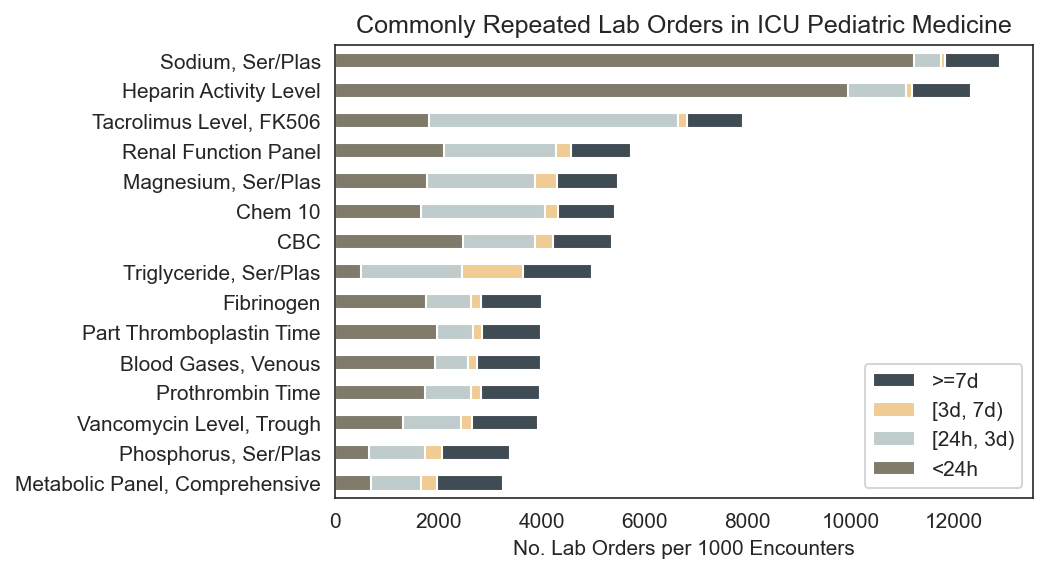

In [39]:
# labdtq = pd.read_csv('data/labdtq.csv', index_col=0)
ax1 = labdtq.iloc[3].plot.barh(color='#404c54');
labdtq.iloc[2].plot.barh(ax=ax1, color='#f0cc94');
labdtq.iloc[1].plot.barh(ax=ax1, color='#c0cccc');
labdtq.iloc[0].plot.barh(ax=ax1, color='#807A6B');
ax1.legend();
ax1.invert_yaxis();
ax1.set_title('Commonly Repeated Lab Orders in ICU Pediatric Medicine');
ax1.set_xlabel('No. Lab Orders per 1000 Encounters');

## Lab Component Stability

In [24]:
def windowedLabCounts(LABNAME, LOWER, UPPER, plot_flag = False):
    lrdf = lradt.loc[(lradt.base_name==LABNAME) & (lradt.ord_num_value < UPPER) & (lradt.ord_num_value > LOWER)].sort_values(by=['pat_enc_csn_id_coded', 'result_time']).reset_index()
    lrdf['result'] = 'N'
    lrdf.loc[(lrdf.result_in_range_yn!='Y') & ((lrdf.result_flag=='High') | (lrdf.result_flag=='High Panic')), 'result'] = 'H'
    lrdf.loc[(lrdf.result_in_range_yn!='Y') & ((lrdf.result_flag=='Low') | (lrdf.result_flag=='Low Panic')), 'result'] = 'L'
    lrdf['normal'] = (lrdf.result=='N')
    print('LAB:', LABNAME)
    print(lrdf.normal.value_counts())

    lrdf['preceding']=0
    for enc in lrdf.pat_enc_csn_id_coded.unique():
        enc_idx = (lrdf.pat_enc_csn_id_coded==enc)
        df = lrdf.loc[enc_idx, ['result_time', 'normal']]
        rownum = 0
        for (idx, row) in df.iterrows():
            if rownum>0:
                rtime = row.result_time
                dfslice = df.loc[(df.result_time <= rtime) & (df.result_time > rtime - pd.Timedelta('7D'))]
                if dfslice.shift().loc[idx, 'normal']==True:
                    y = dfslice.shift().normal
                    prec = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
                    lrdf.loc[idx, 'preceding'] = prec.values[-1]
            rownum = rownum + 1
    
    if plot_flag:
        dfstab = lrdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
        dfstab['prop'] = dfstab['normal']['sum']/dfstab['normal']['count'].astype('float')
        ax = dfstab.prop.plt()
        ax.set_xlabel('Consecutive Normal Results in Past 7 Days Preceding Lab');
        ax.set_ylabel('Proportion Normal Results');
        ax.set_title('Stability for Common Inpatient Laboratory Studies');
        ax.set_ylim(0, 1.0);
    
    return lrdf

In [25]:
nadf = windowedLabCounts('NA', 0, 200);
kdf = windowedLabCounts('K', 0, 8);
mgdf = windowedLabCounts('MG', 0, 10);
phosdf = windowedLabCounts('PHOS', 0, 50);
crdf = windowedLabCounts('CR', 0, 20);
wbcdf = windowedLabCounts('WBC', 0, 100000);
hgbdf = windowedLabCounts('HGB', 0, 30);
pltdf = windowedLabCounts('PLT', 0, 500000)

LAB: NA
True     66097
False    30706
Name: normal, dtype: int64
LAB: K
True     57773
False    30781
Name: normal, dtype: int64
LAB: MG
True     44335
False    21575
Name: normal, dtype: int64
LAB: PHOS
True     46362
False    26313
Name: normal, dtype: int64
LAB: CR
True     53941
False    23993
Name: normal, dtype: int64
LAB: WBC
True     30126
False    19168
Name: normal, dtype: int64
LAB: HGB
False    38488
True     20716
Name: normal, dtype: int64
LAB: PLT
True     25644
False    24108
Name: normal, dtype: int64


In [29]:
nastab = nadf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
kstab = kdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
mgstab = mgdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
phosstab = phosdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
crstab = crdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
wbcstab = wbcdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
hgbstab = hgbdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
pltstab = pltdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]

labstab = pd.DataFrame()
labstab['Sodium'] = nastab['normal']['sum']/nastab['normal']['count'].astype('float')
labstab['Potassium'] = kstab['normal']['sum']/kstab['normal']['count'].astype('float')
labstab['Creatinine'] = crstab['normal']['sum']/crstab['normal']['count'].astype('float')
labstab['Magnesium']  = mgstab['normal']['sum']/mgstab['normal']['count'].astype('float')
labstab['Phosphorus'] = phosstab['normal']['sum']/phosstab['normal']['count'].astype('float')
labstab['White Cells'] = wbcstab['normal']['sum']/wbcstab['normal']['count'].astype('float')
labstab['Hemoglobin'] = hgbstab['normal']['sum']/hgbstab['normal']['count'].astype('float')
labstab['Platelets'] = pltstab['normal']['sum']/pltstab['normal']['count'].astype('float')

labstabcnts = pd.DataFrame()
labstabcnts['Sodium'] = nastab['normal']['count']
labstabcnts['Potassium'] = kstab['normal']['count']
labstabcnts['Creatinine'] = crstab['normal']['count']
labstabcnts['Magnesium']  = mgstab['normal']['count']
labstabcnts['Phosphorus'] = phosstab['normal']['count']
labstabcnts['White Cells'] = wbcstab['normal']['count']
labstabcnts['Hemoglobin'] = hgbstab['normal']['count']
labstabcnts['Platelets'] = pltstab['normal']['count']
labstabcnts = pd.melt(labstabcnts.transpose().reset_index(), id_vars='index').rename(columns={'index':'lab'})

labstab.to_csv('data/labstab_icu.csv')
labstabcnts.to_csv('data/labstabcnts_icu.csv')

In [37]:
def plotLabStab(df, ndays, ax = None, subset=False, labs=['']):
    df = df[0:ndays+1]
    if subset:
        df = df[labs]
    sns.set_style("white");
    if ax is None:
        ax = sns.lineplot(data = df, markers=True);
    else:
        sns.lineplot(data = df, markers=True, ax = ax);
    ax.set_xlabel('Consecutive Normal Results in Past 7 Days Preceding Lab');
    ax.set_xlim(-0.25, ndays+0.25)
    ax.set_xticks(np.arange(ndays+1))
    ax.set_ylabel('Proportion Normal Results');
    ax.set_title('Stability for Common ICU Laboratory Studies');
    ax.set_ylim(0, 1.0);
    return ax

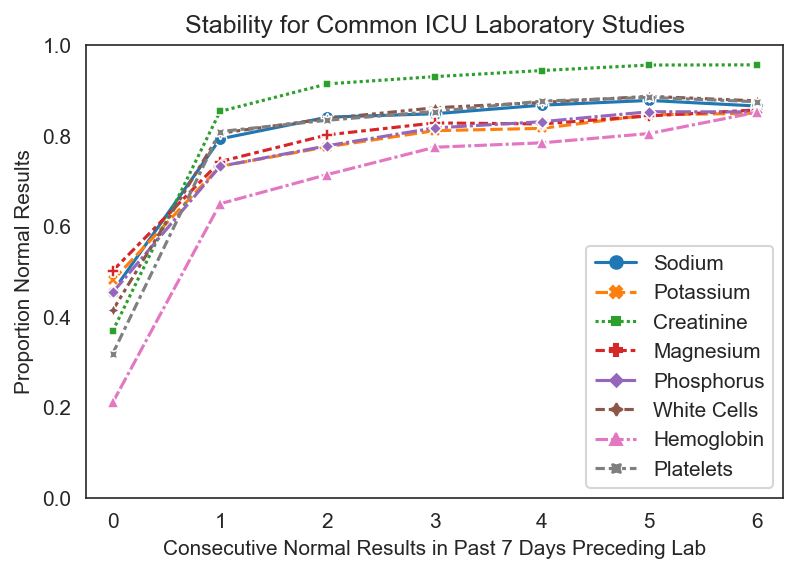

In [38]:
plotLabStab(labstab, 6);

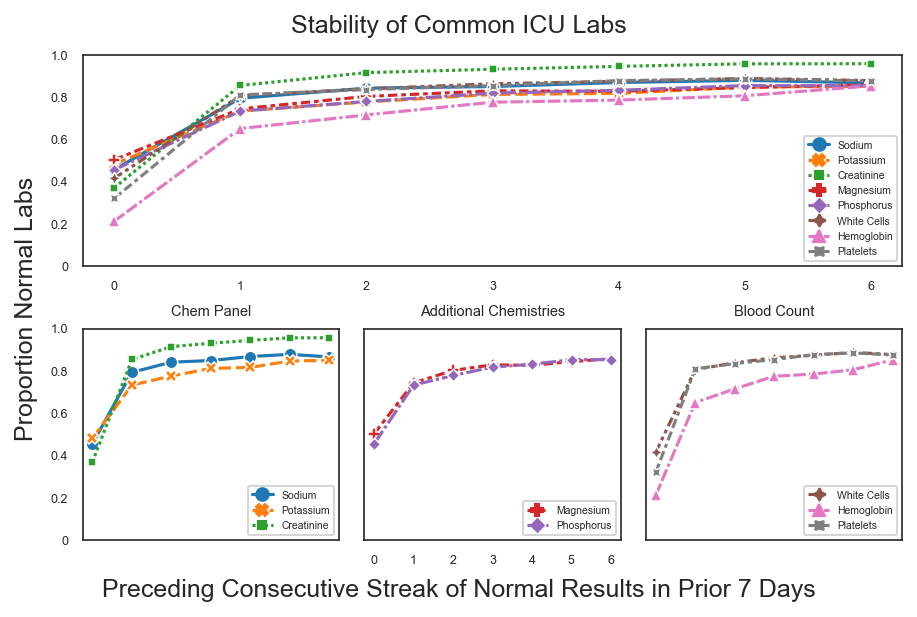

In [36]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)
axes = []
# create sub plots as grid
axes.append(fig.add_subplot(gs[0, :]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1], sharey=axes[1]))
axes.append(fig.add_subplot(gs[1, 2], sharey=axes[1]))

chem1 = ['Sodium', 'Potassium', 'Creatinine']
chem2 = ['Magnesium', 'Phosphorus']
cbc = ['White Cells', 'Hemoglobin', 'Platelets']
cmap = sns.color_palette()

STREAK = 6
sns.set_style("white");
dash_list = sns._core.unique_dashes(8);
marker_list = sns._core.unique_markers(8)
sns.lineplot(data=labstab[0:STREAK+1], ax = axes[0],
             palette = cmap[0:8], dashes=dash_list, markers=marker_list);
sns.lineplot(data=labstab[chem1][0:STREAK+1], ax=axes[1],
             palette = cmap[0:3], dashes=dash_list[0:3], markers=marker_list[0:3])
sns.lineplot(data=labstab[chem2][0:STREAK+1], ax=axes[2], 
             palette = cmap[3:5], dashes=dash_list[3:5], markers=marker_list[3:5])
sns.lineplot(data=labstab[cbc][0:STREAK+1], ax=axes[3], 
             palette = cmap[5:8], dashes=dash_list[5:8], markers=marker_list[5:8])


# plotLabStab(labstab, 6, ax=axes[0]);
# plotLabStab(labstab, 6, ax = axes[1], subset = True, labs = ['Sodium', 'Potassium', 'Creatinine']);
# plotLabStab(labstab, 6, ax = axes[2], subset = True, labs = ['Magnesium', 'Phosphorus']);
# plotLabStab(labstab, 6, ax = axes[3], subset = True, labs = ['White Cells', 'Hemoglobin', 'Platelets']);

for ax in axes:
    ax.set_xlim(-0.25, STREAK+0.25);
    ax.set_ylim(0, 1);
    ax.set_xticks(np.arange(STREAK+1));
    ax.set_xticklabels(labels=np.arange(STREAK+1), fontsize=6);
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=6);
    ax.set_ylabel('');
    ax.set_xlabel('');
    ax.set_title('');
    ax.legend(fontsize=5, loc=4);
    
#axes[0].set_title('All')
axes[1].set_title('Chem Panel', fontsize=7);
axes[2].set_title('Additional Chemistries', fontsize=7);
axes[3].set_title('Blood Count', fontsize=7);
plt.setp(axes[2].get_yticklabels(), visible=False)
plt.setp(axes[3].get_yticklabels(), visible=False)
plt.setp(axes[1].get_xticklabels(), visible=False)
plt.setp(axes[3].get_xticklabels(), visible=False)
axes[0].xaxis.labelpad = 10000;

fig.supylabel('Proportion Normal Labs');
fig.supxlabel('Preceding Consecutive Streak of Normal Results in Prior 7 Days');
fig.suptitle('Stability of Common ICU Labs');

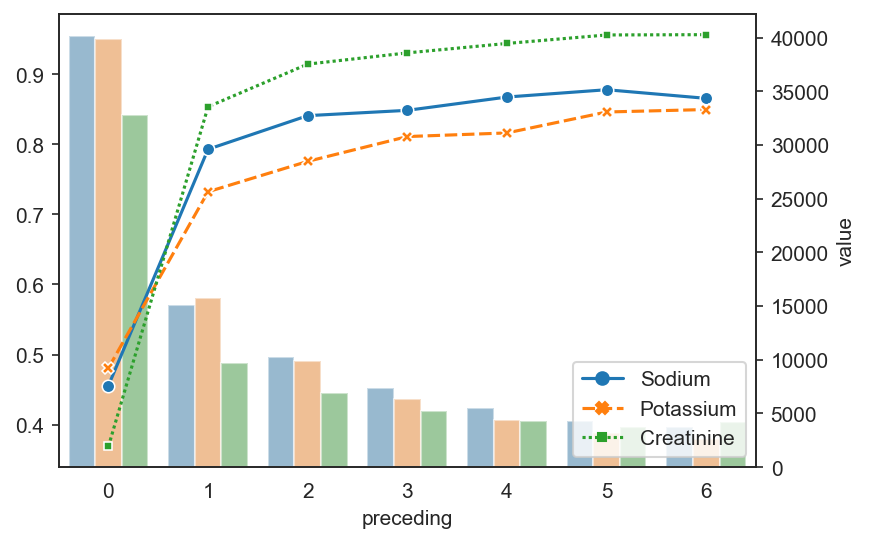

In [33]:
ax1 = sns.lineplot(data=labstab[chem1][0:STREAK+1], 
             palette = cmap[0:3], dashes=dash_list[0:3], markers=marker_list[0:3])
ax1.patch.set_alpha(0)
ax2 = ax1.twinx()
ax2.set_zorder(-1)
g = sns.barplot(data=labstabcnts.loc[labstabcnts.lab.isin(chem1)], hue='lab', x='preceding', y='value',
           palette = cmap[0:3], ax=ax2, alpha=0.5);
ax2.get_legend().remove();

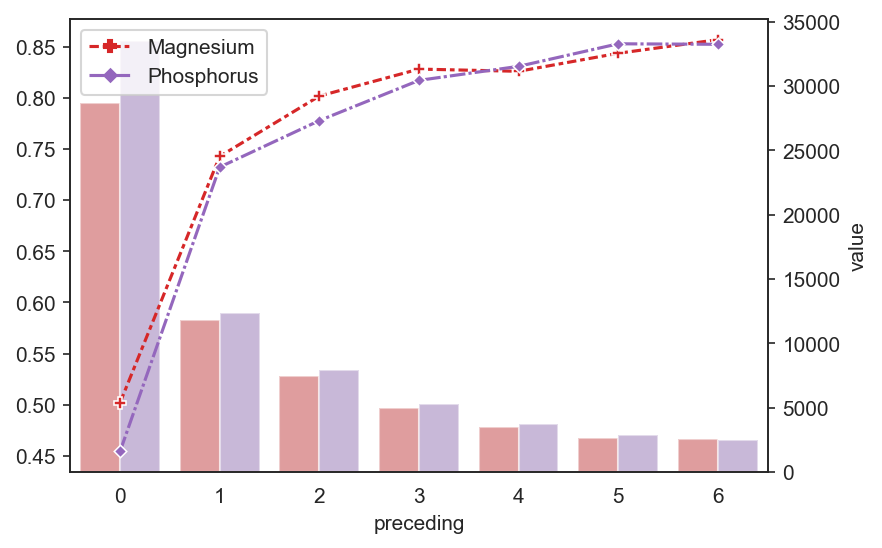

In [34]:
ax1 = sns.lineplot(data=labstab[chem2][0:STREAK+1], 
             palette = cmap[3:5], dashes=dash_list[3:5], markers=marker_list[3:5])
ax1.patch.set_alpha(0)
ax2 = ax1.twinx()
ax2.set_zorder(-1)
g = sns.barplot(data=labstabcnts.loc[labstabcnts.lab.isin(chem2)], hue='lab', x='preceding', y='value',
           palette = cmap[3:5], ax=ax2, alpha=0.5);
ax2.get_legend().remove();

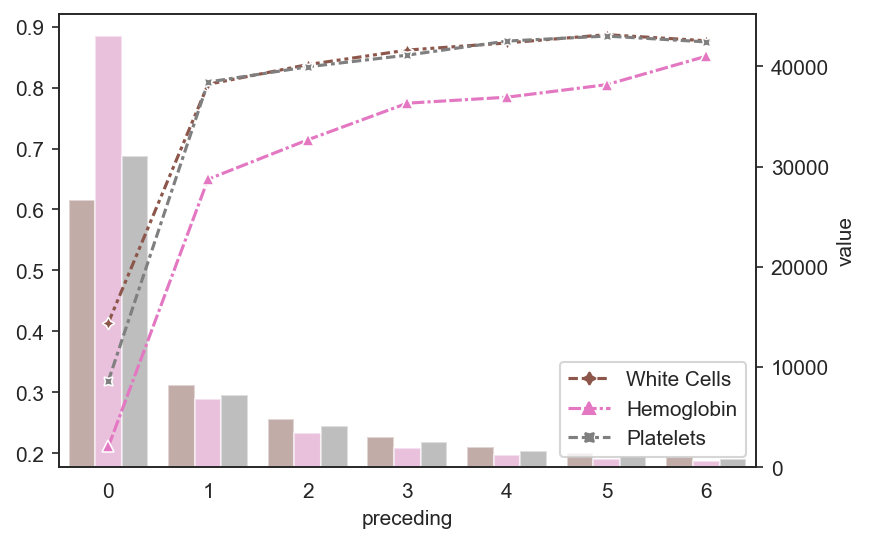

In [35]:
ax1 = sns.lineplot(data=labstab[cbc][0:STREAK+1], 
             palette = cmap[5:8], dashes=dash_list[5:8], markers=marker_list[5:8])
ax1.patch.set_alpha(0)
ax2 = ax1.twinx()
ax2.set_zorder(-1)
g = sns.barplot(data=labstabcnts.loc[labstabcnts.lab.isin(cbc)], hue='lab', x='preceding', y='value',
           palette = cmap[5:8], ax=ax2, alpha=0.5);
ax2.get_legend().remove();